# 📡 Имитационное моделирование RFID системы без коллизий

В этом блокноте проводится **имитационное моделирование UHF RFID системы** с одним считывателем и одной меткой без коллизий. Рассматривается система, представленная в блокноте `3d_model_of_system`, то есть RFID считыватель закреплён на летящем равномерно и прямолинейно БПЛА над полем, на котором находится одна RFID метка. Движение происходит вдоль стены, из-за которой возникает явление многолучевого распространения сигнала, влияющее на уровень потерь в канале между считывателем и меткой.

Данный блокнот воспроизводит ключевые графики, ранее представленные в магистерской диссертации, а именно зависимость вероятности чтения пользовательского банка памяти (USER) метки от:
1) Скорости движения БПЛА со считывателем для разных M и Tari;
2) Высоты полёта БПЛА со считывателем для разных расстояний БПЛА от стены, от которой происходит отражение сигнала;
3) Мощности считывателя в dBm для разных высот полёта БПЛА;
4) Длины пакета передаваемых данных от метки к считывателю для разных мощностей считывателя;
5) ...
6) ...
7) ...

Так как запуск нескольких сетов имитационных RFID моделей (один сет - одна кривая на графике) занимает много времени (десятки минут), в данном блокноте предусмотрена возможность сохранения результатов моделирования в json-файлы. Тогда для построения графиков можно выбрать два варианта: использовать готовые данные из json-файла (быстро, но используются старые данные) или перезапустить модели и построить кривые на основе новых данных (ожидание десятки минут для хорошей статистической устойчивости результатов).


### Импорт необходимых модулей

In [1]:
import numpy as np
import os
import json

from tqdm import tqdm
import matplotlib.pyplot as plt

from pysim.experiments.utility.graphs_style import savefig, GraphConsts, setup_matplotlib
from pysim.models.rfid.cli import prepare_multiple_simulation
from pysim.models.rfid.cli import DEFAULT_TARI, DEFAULT_ENCODING, DEFAULT_TID_WORD_SIZE
from pysim.models.rfid.cli import DEFAULT_READER_OFFSET, DEFAULT_TAG_OFFSET, DEFAULT_ALTITUDE
from pysim.models.rfid.cli import DEFAULT_NUM_TAGS, DEFAULT_POWER, USE_QUERY_ADJUST, DEFAULT_ADJUST_DELTA

In [2]:
JSON_DIRECTORY = 'result_jsons/rfid/'
IMAGE_DIRECTORY = 'rfid' # Название директории, в которой будут сохраняться изображения
setup_matplotlib()

## 📈 Зависимость вероятности чтения банка памяти USER от скорости

Рассматриваются следующие варианты типов кодирования ответов метки (M) и длительности команд считывателя (Tari):
1) M = FM0, Tari = 6,26 мкс
2) M = FM0, Tari = 18,75 мкс
3) M = Miller-2, Tari = 12,5 мкс
4) M = Miller-4, Tari = 6,25 мкс
5) M = Miller-8, Tari = 25 мкс

### ⚙️ Параметры для запуска моделирования

In [3]:
speed_JSON_DIRECTORY = JSON_DIRECTORY + 'speed.json'
speed = np.arange(5.0, 72.5, 2.5) # Исследуемые скорости от 5 до 70 км/ч
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

In [4]:
speed_params_list = []
for coding_params_item in coding_params:
    speed_params_list.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'tid_word_size': DEFAULT_TID_WORD_SIZE,
        'reader_offset': DEFAULT_READER_OFFSET,
        'tag_offset': DEFAULT_TAG_OFFSET,
        'altitude': DEFAULT_ALTITUDE,
        'power': DEFAULT_POWER,
        'num_tags': 30,
        'useadjust': USE_QUERY_ADJUST,
        'delta': DEFAULT_ADJUST_DELTA,
    })

### 💾 Получение результатов

In [5]:
def get_speed_probs(
    speed_params_list: list[dict],
    use_json: bool = True,
    save_results: bool = False
) -> dict[str, list[float]]:
    """
    Получить зависимости вероятностей чтения от скорости.

    Args:
        speed_params_list: список входных параметров для запуска симуляции;
        use_json: использовать ли заранее сохранённые результаты;
        save_results: сохранять ли результаты в json.

    Returns:
        speed_results: словарь, где ключ — строка вида 'M<M_value>_Tari<Tari_value>', 
              значение — список вероятностей чтения USER банка памяти метки.
    """
    if use_json and os.path.exists(speed_JSON_DIRECTORY):
        with open(speed_JSON_DIRECTORY, 'r') as f:
            speed_results = json.load(f)
    else:
        speed_results = {}
        for params in tqdm(speed_params_list, desc='Моделирование по скоростям'):
            results = prepare_multiple_simulation('speed', speed=speed, **params)
            inventory_probs = [res[0]['read_tid_prob'] for res in results]
            key = f"M{params['encoding']}_Tari{params['tari']}"
            speed_results[key] = inventory_probs

            if save_results:
                os.makedirs(os.path.dirname(speed_JSON_DIRECTORY), exist_ok=True)
                with open(speed_JSON_DIRECTORY, 'w') as f:
                    json.dump(speed_results, f, indent=2)
    return speed_results

speed_results = get_speed_probs(speed_params_list, use_json=False, save_results=False)
# Моделирование на M3 Pro с 'num_tags': 2000:
# Моделирование по скоростям: 100%|██████████| 5/5 [41:43<00:00, 500.79s/it]

Моделирование по скоростям: 100%|██████████| 5/5 [00:43<00:00,  8.73s/it]


### 🖼️ Построение графика

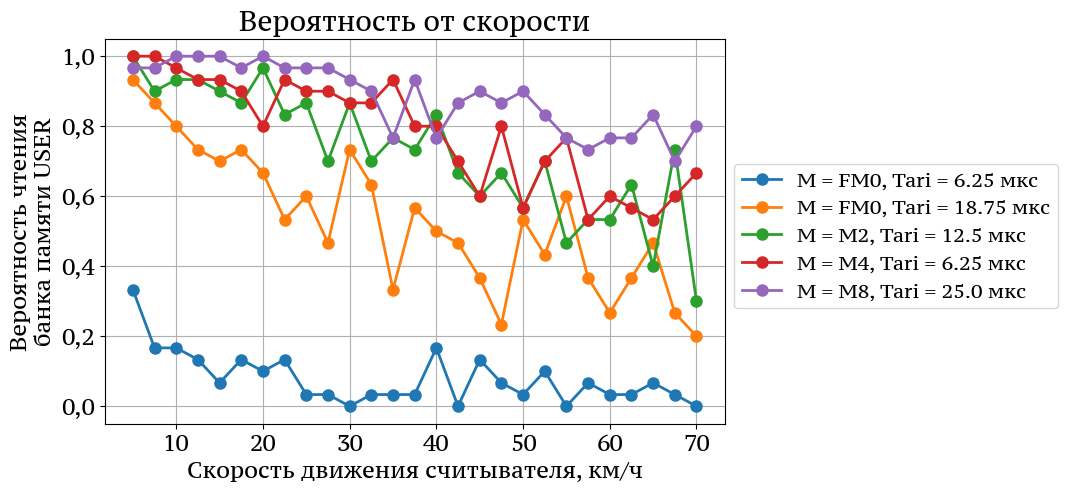

In [6]:
def plot_speed_probs(
    image_name: str = 'Speed probs', save_fig: bool = False
) -> None:
    """
    Построить график зависимости вероятности чтения от скорости движения считывателя.

    Args:
    image_name: имя файла для сохранения изображения;
    save_fig: если True, сохранить график с помощью savefig.
    """
    fig, ax = plt.subplots()
    for coding_params_item in coding_params:
        label = f"M = {coding_params_item['encoding']}, Tari = {coding_params_item['tari']} мкс"
        key = f"M{coding_params_item['encoding']}_Tari{coding_params_item['tari']}"
        inventory_probs = speed_results[key]
        ax.plot(speed, inventory_probs, label=label, marker='o')
    ax.set_xlabel('Скорость движения считывателя, км/ч')
    ax.set_ylabel('Вероятность чтения\nбанка памяти USER')
    ax.set_title('Вероятность от скорости')
    ax.grid()
    ax.legend(bbox_to_anchor=(1, 0.7))
    
    if save_fig:
        savefig(name=image_name, directory=IMAGE_DIRECTORY)

# Вызов функции
plot_speed_probs(save_fig=True)

## 📈 Зависимость вероятности чтения банка памяти USER от высоты полёта считывателя
Рассматриваются следующие варианты расстояний БПЛА со считывателем от стены
1) 0,5 м
2) 1 м
3) 1,5 м
4) 2 м
5) 2,5 м
6) 3 м

### ⚙️ Параметры для запуска моделирования

In [7]:
altitude_JSON_DIRECTORY = JSON_DIRECTORY + 'altitude.json'
altitudes = np.arange(0.5, 7.5, 0.5)  # Исследуемые высоты от 0.5 до 7 м
offset_params = [
    {'reader_offset': 0.5},
    {'reader_offset': 1},
    {'reader_offset': 1.5},
    {'reader_offset': 2},
    {'reader_offset': 2.5},
    {'reader_offset': 3},
]

In [8]:
altitude_params_list = []
for offset_params_item in offset_params:
    altitude_params_list.append({
        'tari': 12.5,
        'encoding': 'M2',
        'tid_word_size': DEFAULT_TID_WORD_SIZE,
        'reader_offset': offset_params_item['reader_offset'],
        'tag_offset': DEFAULT_TAG_OFFSET,
        'power': DEFAULT_POWER,
        'num_tags': 500,
        'useadjust': USE_QUERY_ADJUST,
        'delta': DEFAULT_ADJUST_DELTA,
        'speed': 30
    })

### 💾 Получение результатов

In [9]:
def get_altitude_probs(
    altitude_params_list: list[dict],
    use_json: bool = True,
    save_results: bool = False
) -> list[float]:
    """
    Получить зависимости вероятностей чтения от высоты.

    Args:
        altitude_params_list: список входных параметров для запуска симуляции;
        use_json: использовать ли сохранённые значения;
        save_results: сохранять ли результат.

    Returns:
        altitude_probs: вероятностей чтения USER банка.
    """
    if use_json and os.path.exists(altitude_JSON_DIRECTORY):
        with open(altitude_JSON_DIRECTORY, 'r') as f:
            altitude_results = json.load(f)
    else:
        altitude_results = {}
        for params in tqdm(altitude_params_list, desc='Моделирование по высоте'):
            results = prepare_multiple_simulation('altitude', altitude=altitudes, **params)
            inventory_probs = [res[0]['read_tid_prob'] for res in results]
            key = f"reader_offset{params['reader_offset']}"
            altitude_results[key] = inventory_probs

        if save_results:
            os.makedirs(os.path.dirname(altitude_JSON_DIRECTORY), exist_ok=True)
            with open(altitude_JSON_DIRECTORY, 'w') as f:
                json.dump(altitude_results, f, indent=2)
    return altitude_results

altitude_results = get_altitude_probs(altitude_params_list, use_json=True, save_results=False)
# Моделирование на M3 Pro с 'num_tags': 500:
# Моделирование по высоте: 100%|██████████| 6/6 [06:08<00:00, 61.39s/it]

### 🖼️ Построение графика

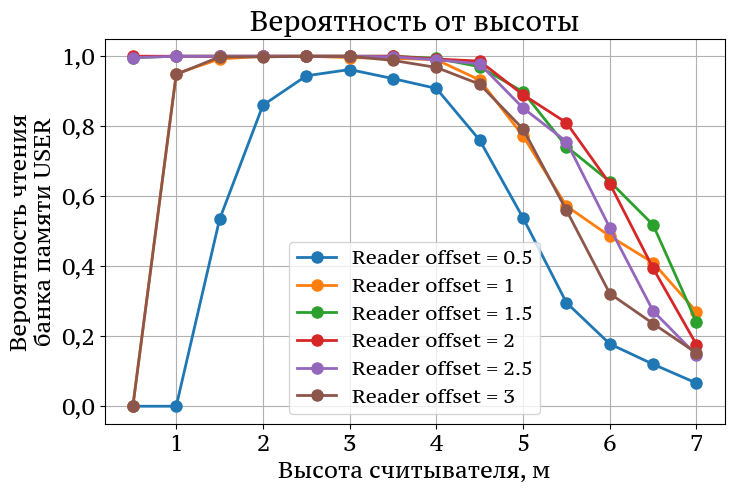

In [10]:
def plot_altitude_probs(
    image_name: str = 'Altitude probs', save_fig: bool = False
) -> dict[str, list[float]]:
    """
    Построить график зависимости вероятности чтения от высоты.

    Args:
        image_name: имя файла для сохранения изображения;
        save_fig: если True, сохранить график.
    """
    fig, ax = plt.subplots()
    for offset_params_item in offset_params:
        label = f"Reader offset = {offset_params_item['reader_offset']}"
        key = f"reader_offset{offset_params_item['reader_offset']}"
        inventory_probs = altitude_results[key]
        ax.plot(altitudes, inventory_probs, label=label, marker='o')

    ax.set_xlabel('Высота считывателя, м')
    ax.set_ylabel('Вероятность чтения\nбанка памяти USER')
    ax.set_title('Вероятность от высоты')
    ax.grid()
    ax.legend()

    if save_fig:
        savefig(name=image_name, directory=IMAGE_DIRECTORY)

plot_altitude_probs(save_fig=True)

## 📈 Зависимость вероятности чтения банка памяти USER от мощности считывателя
Рассматриваются следующие варианты высоты полёта БПЛА со считывателем:
1) 1 м
2) 3 м
3) 5 м
4) 7 м

### ⚙️ Параметры для запуска моделирования

In [11]:
power_JSON_DIRECTORY = JSON_DIRECTORY + 'power.json'
powers = np.arange(19.0, 32.0, 0.5)
altitude_params = [
    {'altitude': 1},
    {'altitude': 3},
    {'altitude': 5},
    {'altitude': 7},
]

In [12]:
power_params_list = []
for alt in altitude_params:
    power_params_list.append({
        'tari': 12.5,
        'encoding': 'M2',
        'tid_word_size': DEFAULT_TID_WORD_SIZE,
        'reader_offset': 2,
        'tag_offset': DEFAULT_TAG_OFFSET,
        'altitude': alt['altitude'],
        'num_tags': 750,
        'useadjust': USE_QUERY_ADJUST,
        'delta': DEFAULT_ADJUST_DELTA,
        'speed': 30,
    })

### 💾 Получение результатов

In [13]:
def get_power_probs(
    power_params_list: list[dict],
    use_json: bool = True,
    save_results: bool = False
) -> dict[str, list[float]]:
    """
    Получить зависимости вероятностей чтения от мощности считывателя.

    Args:
        power_params_list: список конфигураций с разной высотой;
        use_json: использовать ли json;
        save_results: сохранить ли json.

    Returns:
        power_results: словарь с ключами по высоте и значениями — списками вероятностей.
    """
    if use_json and os.path.exists(power_JSON_DIRECTORY):
        with open(power_JSON_DIRECTORY, 'r') as f:
            power_results = json.load(f)
    else:
        power_results = {}
        for params in tqdm(power_params_list, desc='Моделирование по мощности'):
            results = prepare_multiple_simulation('power', power=powers, **params)
            key = f"altitude{params['altitude']}"
            power_results[key] = [res[0]['read_tid_prob'] for res in results]

        if save_results:
            os.makedirs(os.path.dirname(power_JSON_DIRECTORY), exist_ok=True)
            with open(power_JSON_DIRECTORY, 'w') as f:
                json.dump(power_results, f, indent=2)
    return power_results

power_results = get_power_probs(power_params_list, use_json=True, save_results=False)

# Моделирование на M3 Pro с 'num_tags': 750:
# Моделирование по мощности: 100%|██████████| 4/4 [09:42<00:00, 145.58s/it]

### 🖼️ Построение графика

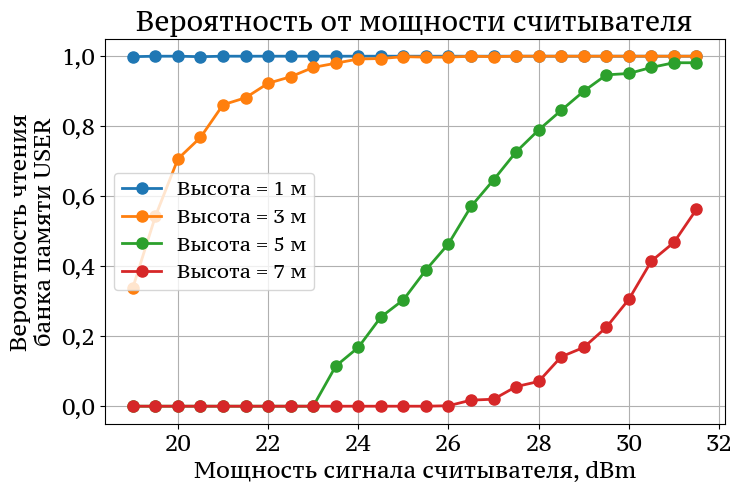

In [14]:
def plot_power_probs(
    image_name: str = 'Power probs', save_fig: bool = False
) -> None:
    """
    Построить график зависимости вероятности чтения от мощности считывателя.

    Args:
        image_name: имя файла;
        save_fig: если True, сохранить.
    """
    fig, ax = plt.subplots()
    for alt in altitude_params:
        label = f"Высота = {alt['altitude']} м"
        key = f"altitude{alt['altitude']}"
        inventory_probs = power_results[key]
        ax.plot(powers, inventory_probs, label=label, marker='o')

    ax.set_xlabel('Мощность сигнала считывателя, dBm')
    ax.set_ylabel('Вероятность чтения\nбанка памяти USER')
    ax.set_title('Вероятность от мощности считывателя')
    ax.grid()
    ax.legend()

    if save_fig:
        savefig(name=image_name, directory=IMAGE_DIRECTORY)

plot_power_probs(save_fig=True)

## 📈 Зависимость вероятности чтения банка памяти USER от величины банка USER
Рассматриваются следующие варианты мощности считывателя:
1) 27 dBm
2) 29 dBm
3) 31,5 dBm

### ⚙️ Параметры для запуска моделирования

In [15]:
length_JSON_DIRECTORY = JSON_DIRECTORY + 'length.json'
tid_lengths = list(range(16, 257, 16))  # от 16 до 256 с шагом 16
power_params = [
    {'power': 27},
    {'power': 29},
    {'power': 31.5},
]

In [16]:
length_params_list = []
for power in power_params:
    length_params_list.append({
        'tari': 12.5,
        'encoding': 'M2',
        'reader_offset': 2,
        'tag_offset': DEFAULT_TAG_OFFSET,
        'altitude': 5,
        'power': power['power'],
        'num_tags': 1000,
        'useadjust': USE_QUERY_ADJUST,
        'delta': DEFAULT_ADJUST_DELTA,
        'speed': 30,
    })

### 💾 Получение результатов

In [17]:
def get_length_probs(
    length_params_list: list[dict],
    use_json: bool = True,
    save_results: bool = False
) -> dict[str, list[float]]:
    """
    Получить зависимости вероятности чтения от длины TID-блока.

    Returns:
        length_results: словарь с ключами по мощности и значениями — списками вероятностей.
    """
    if use_json and os.path.exists(length_JSON_DIRECTORY):
        with open(length_JSON_DIRECTORY, 'r') as f:
            length_results = json.load(f)
    else:
        length_results = {}
        for params in tqdm(length_params_list, desc='Моделирование по длине пакета'):
            results = prepare_multiple_simulation('tid_word_size', tid_word_size=tid_lengths, **params)
            key = f"power{params['power']}"
            length_results[key] = [res[0]['read_tid_prob'] for res in results]

        if save_results:
            os.makedirs(os.path.dirname(length_JSON_DIRECTORY), exist_ok=True)
            with open(length_JSON_DIRECTORY, 'w') as f:
                json.dump(length_results, f, indent=2)
    return length_results

length_results = get_length_probs(length_params_list, use_json=False, save_results=True)

# Моделирование на M3 Pro с 'num_tags': 1000:
# Моделирование по длине пакета: 100%|██████████| 3/3 [04:56<00:00, 98.89s/it] 

Моделирование по длине пакета: 100%|██████████| 3/3 [04:56<00:00, 98.89s/it] 


### 🖼️ Построение графика

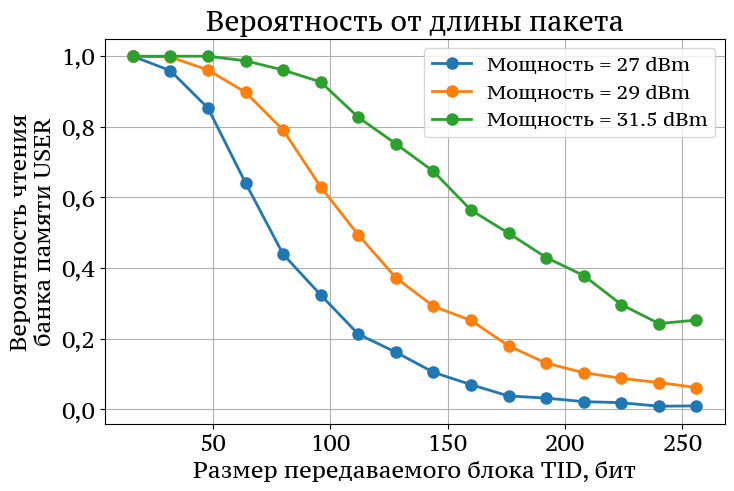

In [18]:
def plot_length_probs(
    image_name: str = 'Length probs', save_fig: bool = False
) -> None:
    """
    Построить график зависимости вероятности чтения от длины передаваемого пакета.

    Args:
        image_name: имя файла;
        save_fig: сохранить ли график.
    """
    fig, ax = plt.subplots()
    for power in power_params:
        label = f"Мощность = {power['power']} dBm"
        key = f"power{power['power']}"
        inventory_probs = length_results[key]
        ax.plot(tid_lengths, inventory_probs, label=label, marker='o')

    ax.set_xlabel('Размер передаваемого блока TID, бит')
    ax.set_ylabel('Вероятность чтения\nбанка памяти USER')
    ax.set_title('Вероятность от длины пакета')
    ax.grid()
    ax.legend()

    if save_fig:
        savefig(name=image_name, directory=IMAGE_DIRECTORY)

plot_length_probs(save_fig=True)